# Create the DataFrame

In [5]:
import urllib.request
from bs4 import BeautifulSoup # HTML, XML Document 데이터를 읽기 위한 라이브러리
import pandas as pd
import datetime as dt


def strptime_statedt(x):
    return dt.datetime.strptime(x, '%Y%m%d')

serviceKey = '0Nxjl3xb59fkPcq7n0%2FoeaP1%2BvZy8L1l%2B4NunrGvuPrFcORrGfI2caBJ2dzsJA6VZWYw6XGIJ0hH2%2Bx9V74bUQ%3D%3D'
startCreateDt = '20200214'
endCreateDt = '20201216'
url_xml = str('http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson?serviceKey=' + serviceKey + 
              '&startCreateDt=' + startCreateDt + '&endCreateDt=' + endCreateDt)

response = urllib.request.urlopen(url_xml)
response_code = response.getcode()


corona_df = pd.DataFrame({'statedt': [], 'createdt': [], 'decidecnt': [], 'examcnt':[], 'clearcnt':[], 'deathcnt':[]})

if response_code == 200:
    response_body = response.read().decode('utf-8') # decode('utf-8') : 바이트열 -> 문자열(복호화)
    soup = BeautifulSoup(response_body, 'html.parser') # xml도 가능
    dataList = soup.find_all('item')

    for data in dataList:
        # 마지막행에 데이터 추가 (모두 문자열로 받아옴)
        corona_df.loc[len(corona_df.index)] = [data.statedt.text, data.createdt.text, data.decidecnt.text, data.examcnt.text, data.clearcnt.text, data.deathcnt.text]
        
    ##### 데이터프레임 정렬 #####
    corona_df['statedt'] = corona_df['statedt'].apply(strptime_statedt) # statedt기준 정렬을 위해 날짜형식으로 변환
    corona_df['createdt'] = pd.to_datetime(corona_df['createdt']) # 날짜형식으로 변환
    corona_df['decidecnt'] = corona_df['decidecnt'].astype('int') # 정수형으로 변환
    
    # statedt(기준일) 기준으로는 오름차순, createdt(등록일시분초) 기준으로는 내림차순 정렬
    corona_df = corona_df.sort_values(by=["statedt", "createdt"], ascending=[True, False])
    
    # statedt열에서 중복행 제거(처음 나타난 데이터는 보존 = 그 날의 가장최신 데이터)
    corona_df = corona_df.drop_duplicates(subset=['statedt'])
    
    
    ##### 일별 확진자수 #####
    corona_df['shift_down'] = corona_df['decidecnt'].shift(+1).fillna(0)
    corona_df['decidecnt_day'] = corona_df['decidecnt'] - corona_df['shift_down']
    corona_df['decidecnt_day'] = corona_df['decidecnt_day'].astype('int')
    corona_df.drop(corona_df.index[0], inplace=True) # 첫번째 행 제거(일별확진자 수 계산하는과정에서 첫행은 누적값 그대로 들어가기때문)
    
print(corona_df.info())
corona_df['statedt'] = corona_df['statedt'].astype('str')
print(corona_df.info())

corona_df.set_index('statedt', inplace=True)
display(corona_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 329 to 0
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   statedt        306 non-null    datetime64[ns]
 1   createdt       306 non-null    datetime64[ns]
 2   decidecnt      306 non-null    int32         
 3   examcnt        306 non-null    object        
 4   clearcnt       306 non-null    object        
 5   deathcnt       306 non-null    object        
 6   shift_down     306 non-null    float64       
 7   decidecnt_day  306 non-null    int32         
dtypes: datetime64[ns](2), float64(1), int32(2), object(3)
memory usage: 19.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 329 to 0
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   statedt        306 non-null    object        
 1   createdt       306 non-null    dateti

,createdt,decidecnt,examcnt,clearcnt,deathcnt,shift_down,decidecnt_day
statedt,,,,,,,
2020-02-15,2020-02-15 17:00:21.210,28,558,9,0,28.0,0
2020-02-16,2020-02-16 16:57:02.020,29,485,9,0,28.0,1
2020-02-17,2020-02-17 16:50:47.470,30,708,10,0,29.0,1
2020-02-18,2020-02-18 16:42:00.000,31,818,12,0,30.0,1
2020-02-19,2020-02-19 17:00:13.130,51,1149,16,0,31.0,20
...,...,...,...,...,...,...,...
2020-12-12,2020-12-12 09:19:01.382,41736,86742,31493,578,40786.0,950
2020-12-13,2020-12-13 09:48:21.971,42766,90129,31814,580,41736.0,1030
2020-12-14,2020-12-14 09:38:10.035,43484,89247,32102,587,42766.0,718


# Graph Visualization

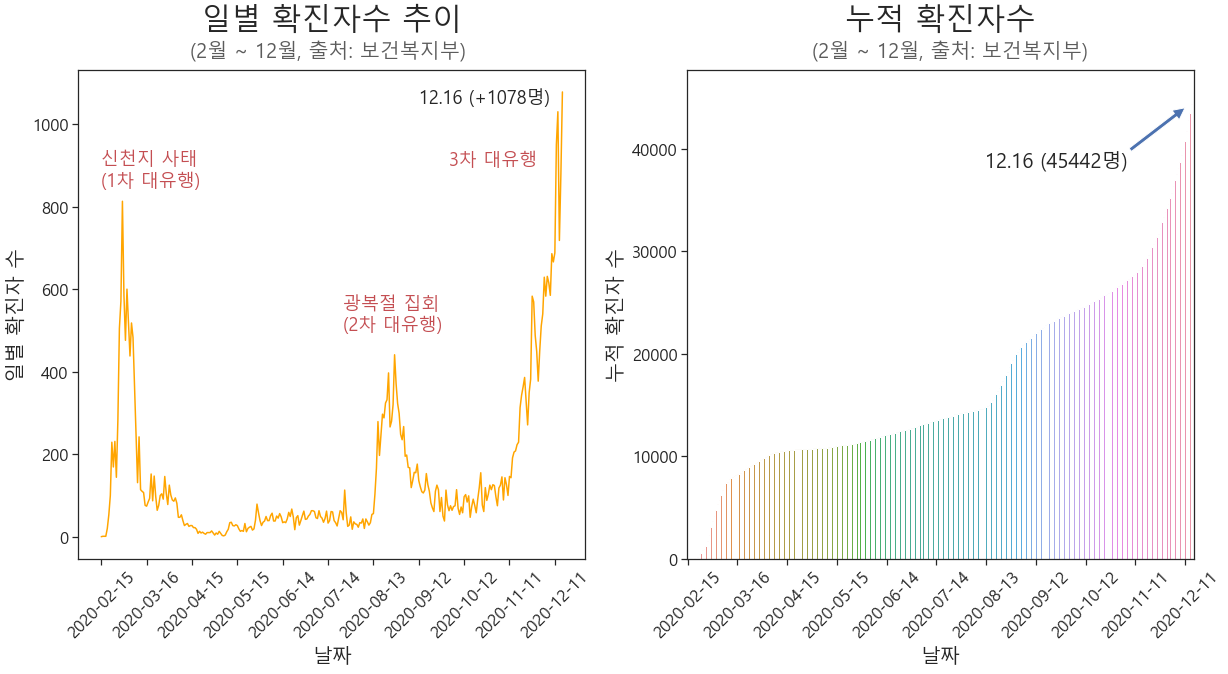

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

### 폰트 오류 해결 ###
from matplotlib import font_manager, rc
font_path = "./malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)
######################


# 그래프 객체 생성 (figure에 2개의 서브 플롯을 생성)
fig = plt.figure(figsize=(20,9))   
ax1 = fig.add_subplot(1,2, 1)
ax2 = fig.add_subplot(1,2, 2)
sns.set(font_scale=1.5)

##### 꺾은선 그래프 #####
lineplot = sns.lineplot(x=corona_df.index, y='decidecnt_day', data=corona_df, ax=ax1, color='orange')

lineplot.set_title('일별 확진자수 추이', fontsize=30, pad=40)
### 폰트 오류 해결 ###
from matplotlib import font_manager, rc
font_path = "./malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)
######################
plt.text(x=-300, y=49000, s='(2월 ~ 12월, 출처: 보건복지부)', fontsize=20, alpha=0.75)
lineplot.set_xlabel('날짜', fontsize=20)
lineplot.set_ylabel('일별 확진자 수', fontsize=20)
sns.set_style('white')
sns.set_style('ticks')


# Matplotlib에서 플롯 업데이트를 자동화하기 위해 데이터를 업데이트하고 기존 플롯을 지우고 업데이트 된 데이터를 루프로 플롯한다.
plt.draw() # 기존 플롯을 지우기위해 plt.draw() 메서드 이용
### 폰트 오류 해결 ###
from matplotlib import font_manager, rc
font_path = "./malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)
######################

lineplot_ticks = lineplot.get_xticks() # 18293. 18322. 18353. 18383. 18414. 18444. 18475. 18506. 18536. 18567. 18597.
lineplot_labels = lineplot.get_xticklabels() # Text(18293.0, 0, '2020-02'), Text(18322.0, 0, '2020-03'), ..., Text(18597.0, 0, '2020-12')

lineplot_labels_list = []
for i in range(len(lineplot_labels)):
    lineplot_labels_list.append(lineplot_labels[i].get_text()[0:10])
lineplot.set_xticks(lineplot_ticks[0::30])
lineplot.set_xticklabels(lineplot_labels_list[0::30], rotation=45);
ax1.annotate(text='신천지 사태\n(1차 대유행)', xy=(0,850), xycoords='data', color='r')
ax1.annotate(text='광복절 집회\n(2차 대유행)', xy=(160,500), xycoords='data', color='r')
ax1.annotate(text='3차 대유행', xy=(230,900), xycoords='data', color='r')
ax1.annotate(text='12.16 (+1078명)', xy=(210,1050), xycoords='data')



##### 누적 막대그래프 #####
barplot = sns.barplot(x=corona_df.index, y='decidecnt', data=corona_df, ax=ax2)

barplot.set_title('누적 확진자수', fontsize=30, pad=40)
plt.text(x=75, y=49000, s='(2월 ~ 12월, 출처: 보건복지부)', fontsize=20, alpha=0.75)
barplot.set_xlabel('날짜', fontsize=20)
barplot.set_ylabel('누적 확진자 수', fontsize=20)

barplot_ticks = barplot.get_xticks() # 0, 1, 2, ... , 305
barplot_labels = barplot.get_xticklabels() # Text(0, 0, '2020-02-15 00:00:00'), Text(1, 0, '2020-02-16 00:00:00'), ..., Text(305, 0, '2020-12-07 00:00:00')

barplot_labels_list = []
for i in range(len(barplot_labels)):
    barplot_labels_list.append(barplot_labels[i].get_text()[0:10])
barplot.set_xticks(barplot_ticks[0::30])
barplot.set_xticklabels(barplot_labels_list[0::30], rotation=45)
decidecnt = corona_df['decidecnt'][-1]
text = "12.16 ({0}명)".format(decidecnt)
ax2.annotate(text=text, xy=(300, 44000), xycoords='data', 
             xytext=(-200,-60), textcoords='offset points', arrowprops={}, fontsize=20)

plt.savefig('./Corona Infection Status(0215~1216).png', bbox_inches='tight')
plt.show()